# Results - Performance summary

## Prepare the data

### Function to obtain optimum F1 score

In [1]:
def getOptimalF1Score(y_true, y_score):

    from numpy import arange
    from numpy import argmax
    from sklearn.metrics import f1_score

    thresholds = arange(0, 1, 0.001)
    scores = [f1_score(y_true, (y_score >= t).astype('int')) for t in thresholds]
    ix = argmax(scores)
    return thresholds[ix], scores[ix]

### Read the required files

In [2]:
import os
import pandas as pd


mimicDataDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/experiments/inter_source_validation/data/data_matrix_mimic_standardised.csv')
eicuDataDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/experiments/inter_source_validation/data/data_matrix_eicu_standardised.csv')
eicuUsingMimicDataDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/experiments/inter_source_validation/prediction/eicu_using_mimic_model_wb_30_wa_30_standardised.csv')
mimicUsingEicuDataDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/experiments/inter_source_validation/prediction/mimic_using_eicu_model_wb_30_wa_30_standardised.csv')

mimicDataDf.shape, eicuDataDf.shape, mimicUsingEicuDataDf.shape, eicuUsingMimicDataDf.shape

((31646, 105), (56237, 106), (6277, 3), (11145, 3))

### Calculate performance metrics

In [6]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


mimicMergedDf = mimicUsingEicuDataDf.merge(
    mimicDataDf[['person_id', 'visit_occurrence_id', 'death_0_30_adm']].drop_duplicates(),
    how='inner',
    on=['person_id', 'visit_occurrence_id']
)

eicuMergedDf = eicuUsingMimicDataDf.merge(
    eicuDataDf[['person_id', 'visit_occurrence_id', 'death_0_30_adm']].drop_duplicates(),
    how='inner',
    on=['person_id', 'visit_occurrence_id']
)

for dataset, mergedDf in [('<mimic using eicu data>', mimicMergedDf), ('<eicu using mimic data>', eicuMergedDf)]:
    cutoffThreshold, optimalF1Score = getOptimalF1Score(y_true=mergedDf['death_0_30_adm'], y_score=mergedDf.preds)
    cutoff = cutoffThreshold

    accuracy = accuracy_score(y_true=mergedDf['death_0_30_adm'], y_pred=mergedDf.preds.apply(lambda x: 1 if (x > 0.5) else 0))
    balanced_accuracy = balanced_accuracy_score(y_true=mergedDf['death_0_30_adm'], y_pred=mergedDf.preds.apply(lambda x: 1 if (x > 0.5) else 0))
    average_precision = average_precision_score(y_true=mergedDf['death_0_30_adm'], y_score=mergedDf.preds)
    f1 = f1_score(y_true=mergedDf['death_0_30_adm'], y_pred=mergedDf.preds.apply(lambda x: 1 if (x > 0.5) else 0))
    roc_auc = roc_auc_score(y_true=mergedDf['death_0_30_adm'], y_score=mergedDf.preds)

    print('dataset: ', dataset, 'accuracy: ', accuracy, 'balanced_accuracy: ', balanced_accuracy, 'average_precision: ', average_precision, 'f1: ', f1, 'roc_auc: ', roc_auc)

dataset:  <mimic using eicu data> accuracy:  0.827465349689342 balanced_accuracy:  0.5678682859842352 average_precision:  0.49219580574266353 f1:  0.24843858431644691 roc_auc:  0.7716975602304107
dataset:  <eicu using mimic data> accuracy:  0.8436967249887842 balanced_accuracy:  0.6652506140385492 average_precision:  0.3337129336561998 f1:  0.390909090909091 roc_auc:  0.7656274245345326


## Plot AUROC

### Create a dataframe for AUROC

In [7]:
import numpy as np


plotDf = pd.DataFrame(np.zeros([2, 2])*np.nan, columns=['MIMIC', 'eICU'], index=['MIMIC', 'eICU'])
plotDf.loc['MIMIC', 'MIMIC'] = 0.8084
plotDf.loc['eICU', 'eICU'] = 0.8476
plotDf.loc['MIMIC', 'eICU'] = 0.7716
plotDf.loc['eICU', 'MIMIC'] = 0.7656
plotDf


,MIMIC,eICU
MIMIC,0.8084,0.7716
eICU,0.7656,0.8476


### Plot heatmap

[Text(0.5, 23.52222222222222, 'Training Dataset'),
 Text(50.722222222222214, 0.5, 'Validation Dataset')]

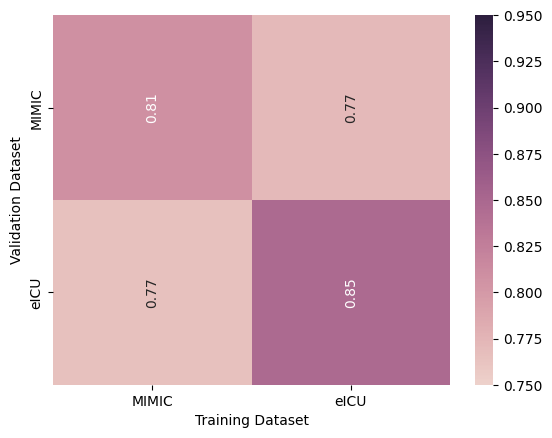

In [8]:
import seaborn as sns


s = sns.heatmap(
    plotDf,
    annot=True,
    fmt=".2f",
    vmin=0.75,
    vmax=0.95,
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot_kws={'rotation': 90},
)
s.set(xlabel='Training Dataset', ylabel='Validation Dataset')


## Plot Accuracy

### Create a dataframe for Accuracy

In [9]:
import numpy as np


plotDf = pd.DataFrame(np.zeros([2, 2])*np.nan, columns=['MIMIC', 'eICU'], index=['MIMIC', 'eICU'])
plotDf.loc['MIMIC', 'MIMIC'] = 0.8487
plotDf.loc['eICU', 'eICU'] = 0.8943
plotDf.loc['MIMIC', 'eICU'] = 0.8274
plotDf.loc['eICU', 'MIMIC'] = 0.8437
plotDf

,MIMIC,eICU
MIMIC,0.8487,0.8274
eICU,0.8437,0.8943


### Plot heatmap

[Text(0.5, 23.52222222222222, 'Training Dataset'),
 Text(50.722222222222214, 0.5, 'Validation Dataset')]

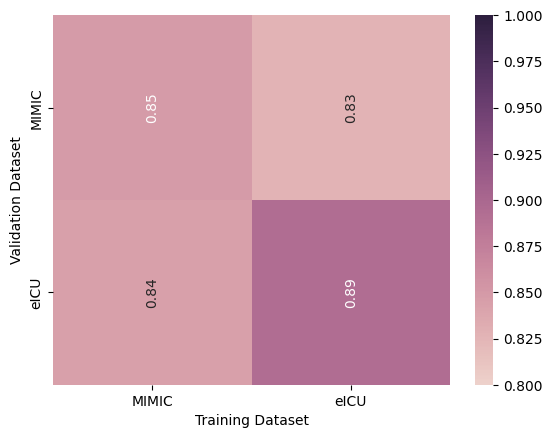

In [10]:
import seaborn as sns


s = sns.heatmap(
    plotDf,
    annot=True,
    fmt=".2f",
    vmin=0.8,
    vmax=1,
    cmap=sns.cubehelix_palette(as_cmap=True),
    annot_kws={'rotation': 90},
)
s.set(xlabel='Training Dataset', ylabel='Validation Dataset')

## Feature Importance Analysis

In [11]:
import os
import pandas as pd


eicuImportanceDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/experiments/inter_source_validation/feature_importance/eicu_wb_30_wa_30_standardised/ensemble_feature_importance.csv''')
mimicImportanceDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '''/data/experiments/inter_source_validation/feature_importance/mimic_wb_30_wa_30_standardised/ensemble_feature_importance.csv''')

eicuImportanceDf.shape, mimicImportanceDf.shape

((100, 2), (100, 2))

In [12]:
import pandas as pd


eicuImportanceDf['Data'] = 'EICU'
mimicImportanceDf['Data'] = 'MIMIC'
plotDf = pd.concat([eicuImportanceDf, mimicImportanceDf])
plotDf

,Feature_Name,Feature_Importance,Data
0,labs_MCHC_avg,0.008869,EICU
1,labs_MCHC_first,0.007223,EICU
2,labs_MCHC_last,0.007982,EICU
3,labs_MCHC_max,0.004813,EICU
4,labs_MCHC_min,0.008709,EICU
...,...,...,...
95,vitals_systemic_systolic_avg,0.026339,MIMIC
96,vitals_systemic_systolic_first,0.020221,MIMIC
97,vitals_systemic_systolic_last,0.089843,MIMIC
98,vitals_systemic_systolic_max,0.036538,MIMIC


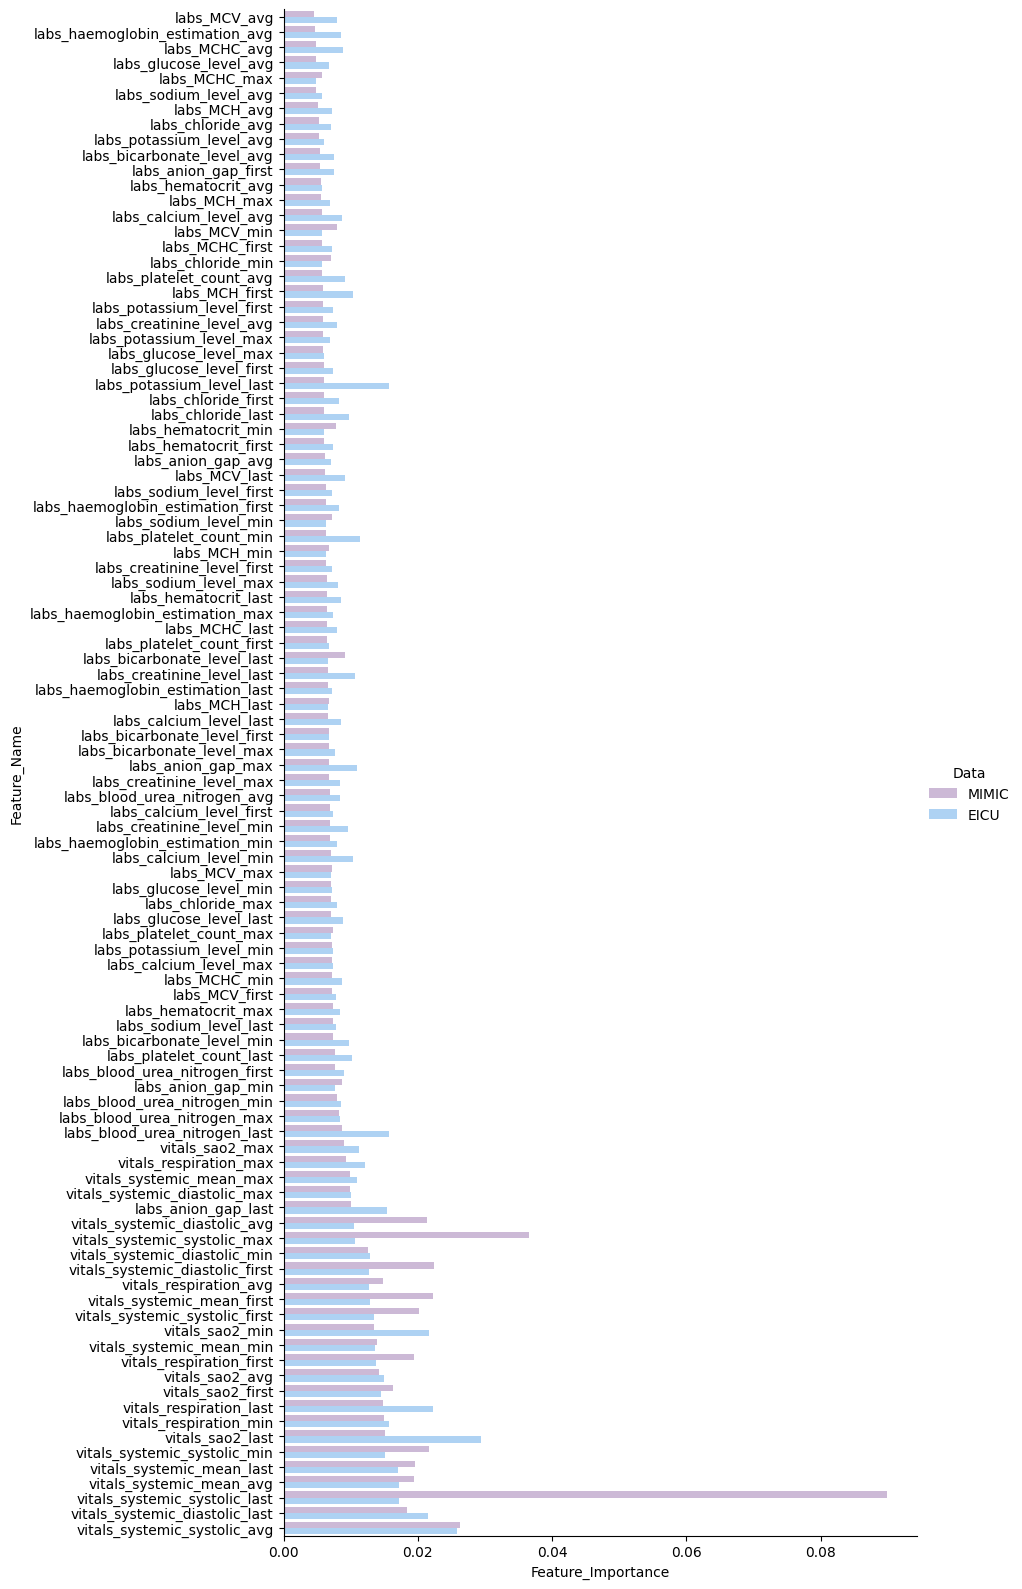

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.catplot(x="Feature_Importance", y="Feature_Name",
                hue="Data",
                data=plotDf.sort_values(by='Feature_Importance'), kind="bar", orient='h',
                palette=['#cdb4db', '#a2d2ff'],
                height=16, aspect=0.6)


In [28]:
plotDf = eicuImportanceDf.add_prefix('MIMIC_').merge(
            mimicImportanceDf.add_prefix('EICU_'),
            how='inner',
            left_on='MIMIC_Feature_Name',
            right_on='EICU_Feature_Name'
        ).drop(
            columns=['EICU_Feature_Name']
        ).rename(columns={'MIMIC_Feature_Name': 'Feature_Name'})
plotDf['diff'] = (((plotDf.MIMIC_Feature_Importance - plotDf.EICU_Feature_Importance)/plotDf.MIMIC_Feature_Importance) * 100)
plotDf

,Feature_Name,MIMIC_Feature_Importance,MIMIC_Data,EICU_Feature_Importance,EICU_Data,diff
0,labs_MCHC_avg,0.008869,EICU,0.004763,MIMIC,46.294219
1,labs_MCHC_first,0.007223,EICU,0.005769,MIMIC,20.129284
2,labs_MCHC_last,0.007982,EICU,0.006527,MIMIC,18.226238
3,labs_MCHC_max,0.004813,EICU,0.005746,MIMIC,-19.373794
4,labs_MCHC_min,0.008709,EICU,0.007255,MIMIC,16.694257
...,...,...,...,...,...,...
95,vitals_systemic_systolic_avg,0.025809,EICU,0.026339,MIMIC,-2.051766
96,vitals_systemic_systolic_first,0.013445,EICU,0.020221,MIMIC,-50.398594
97,vitals_systemic_systolic_last,0.017263,EICU,0.089843,MIMIC,-420.425253
98,vitals_systemic_systolic_max,0.010712,EICU,0.036538,MIMIC,-241.087874


<Axes: xlabel='diff', ylabel='Count'>

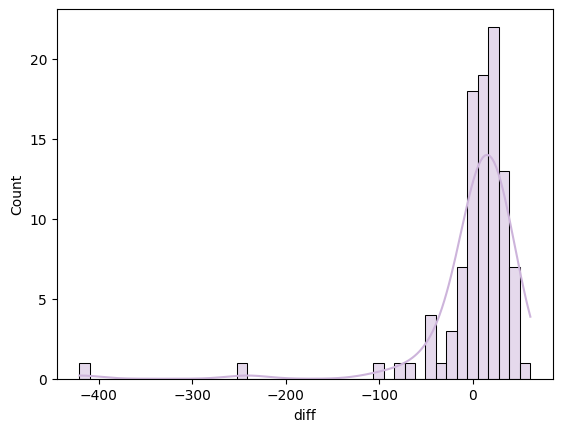

In [34]:
sns.histplot(data=plotDf, x="diff", color='#cdb4db', kde=True)

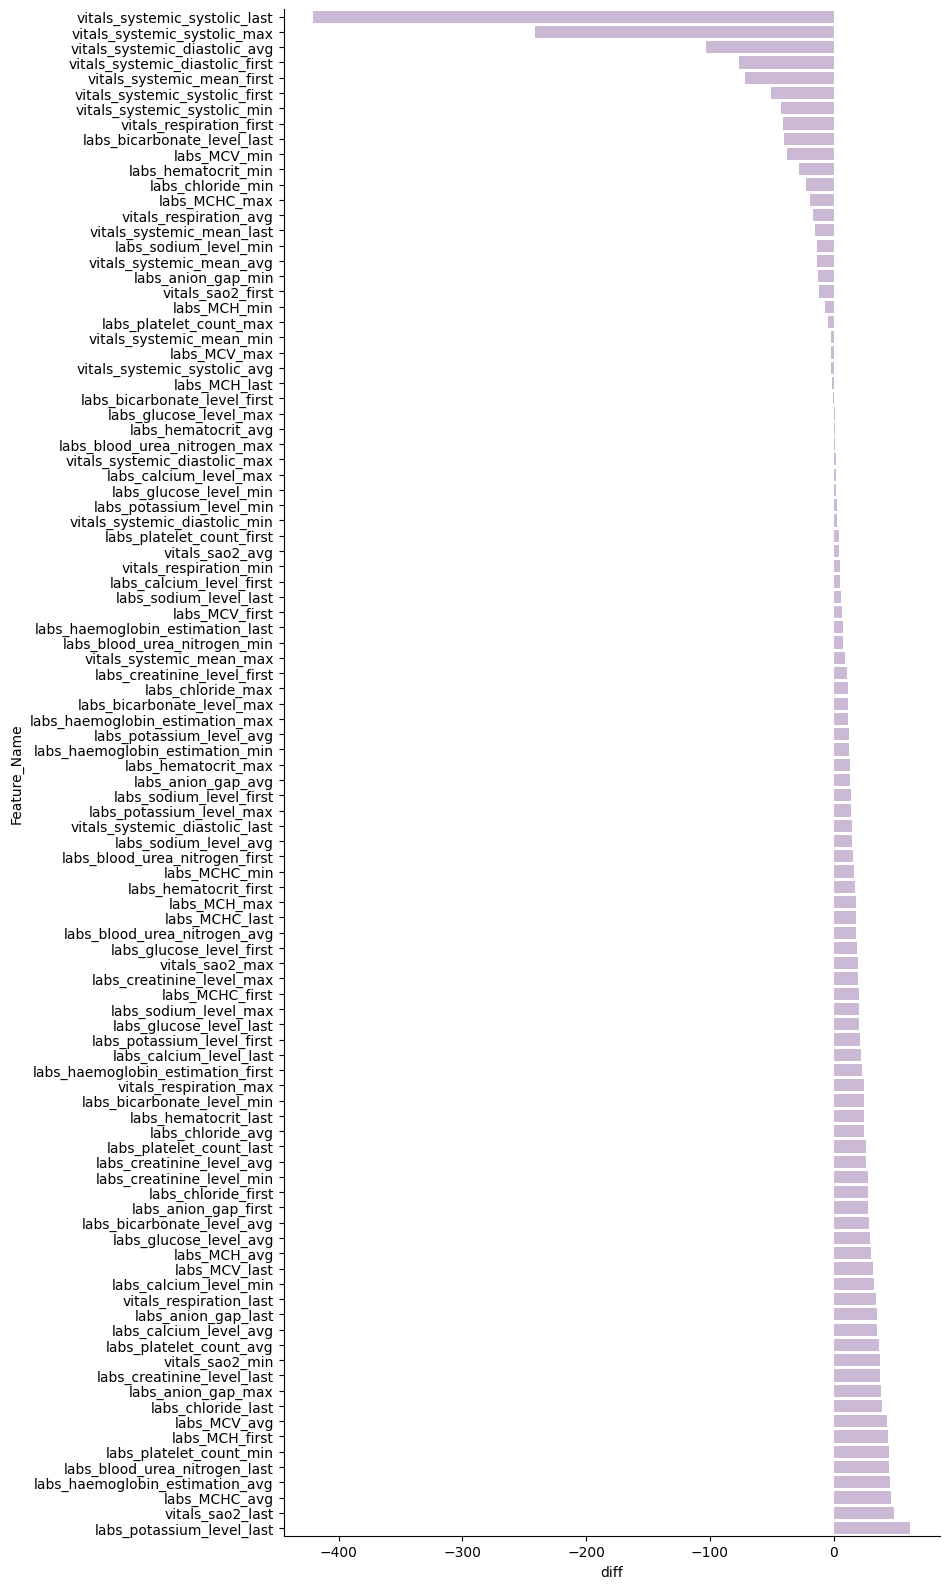

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.catplot(x="diff", y="Feature_Name",
                data=plotDf.sort_values(by='diff'), kind="bar", orient='h', color='#cdb4db',
                height=16, aspect=0.6)


In [17]:
plotDf = eicuImportanceDf.add_prefix('MIMIC_').merge(
            mimicImportanceDf.add_prefix('EICU_'),
            how='inner',
            left_on='MIMIC_Feature_Name',
            right_on='EICU_Feature_Name'
        ).drop(
            columns=['EICU_Feature_Name']
        ).rename(columns={'MIMIC_Feature_Name': 'Feature_Name'})
plotDf['MIMIC_Feature_Rank'] = plotDf['MIMIC_Feature_Importance'].rank()
plotDf['EICU_Feature_Rank'] = plotDf['EICU_Feature_Importance'].rank()
plotDf['diff'] = plotDf.MIMIC_Feature_Rank - plotDf.EICU_Feature_Rank
plotDf

,Feature_Name,MIMIC_Feature_Importance,MIMIC_Data,EICU_Feature_Importance,EICU_Data,MIMIC_Feature_Rank,EICU_Feature_Rank,diff
0,labs_MCHC_avg,0.008869,EICU,0.004763,MIMIC,59.0,3.0,56.0
1,labs_MCHC_first,0.007223,EICU,0.005769,MIMIC,25.0,15.0,10.0
2,labs_MCHC_last,0.007982,EICU,0.006527,MIMIC,45.0,36.0,9.0
3,labs_MCHC_max,0.004813,EICU,0.005746,MIMIC,1.0,14.0,-13.0
4,labs_MCHC_min,0.008709,EICU,0.007255,MIMIC,57.0,60.0,-3.0
...,...,...,...,...,...,...,...,...
95,vitals_systemic_systolic_avg,0.025809,EICU,0.026339,MIMIC,99.0,98.0,1.0
96,vitals_systemic_systolic_first,0.013445,EICU,0.020221,MIMIC,83.0,93.0,-10.0
97,vitals_systemic_systolic_last,0.017263,EICU,0.089843,MIMIC,95.0,100.0,-5.0
98,vitals_systemic_systolic_max,0.010712,EICU,0.036538,MIMIC,73.0,99.0,-26.0


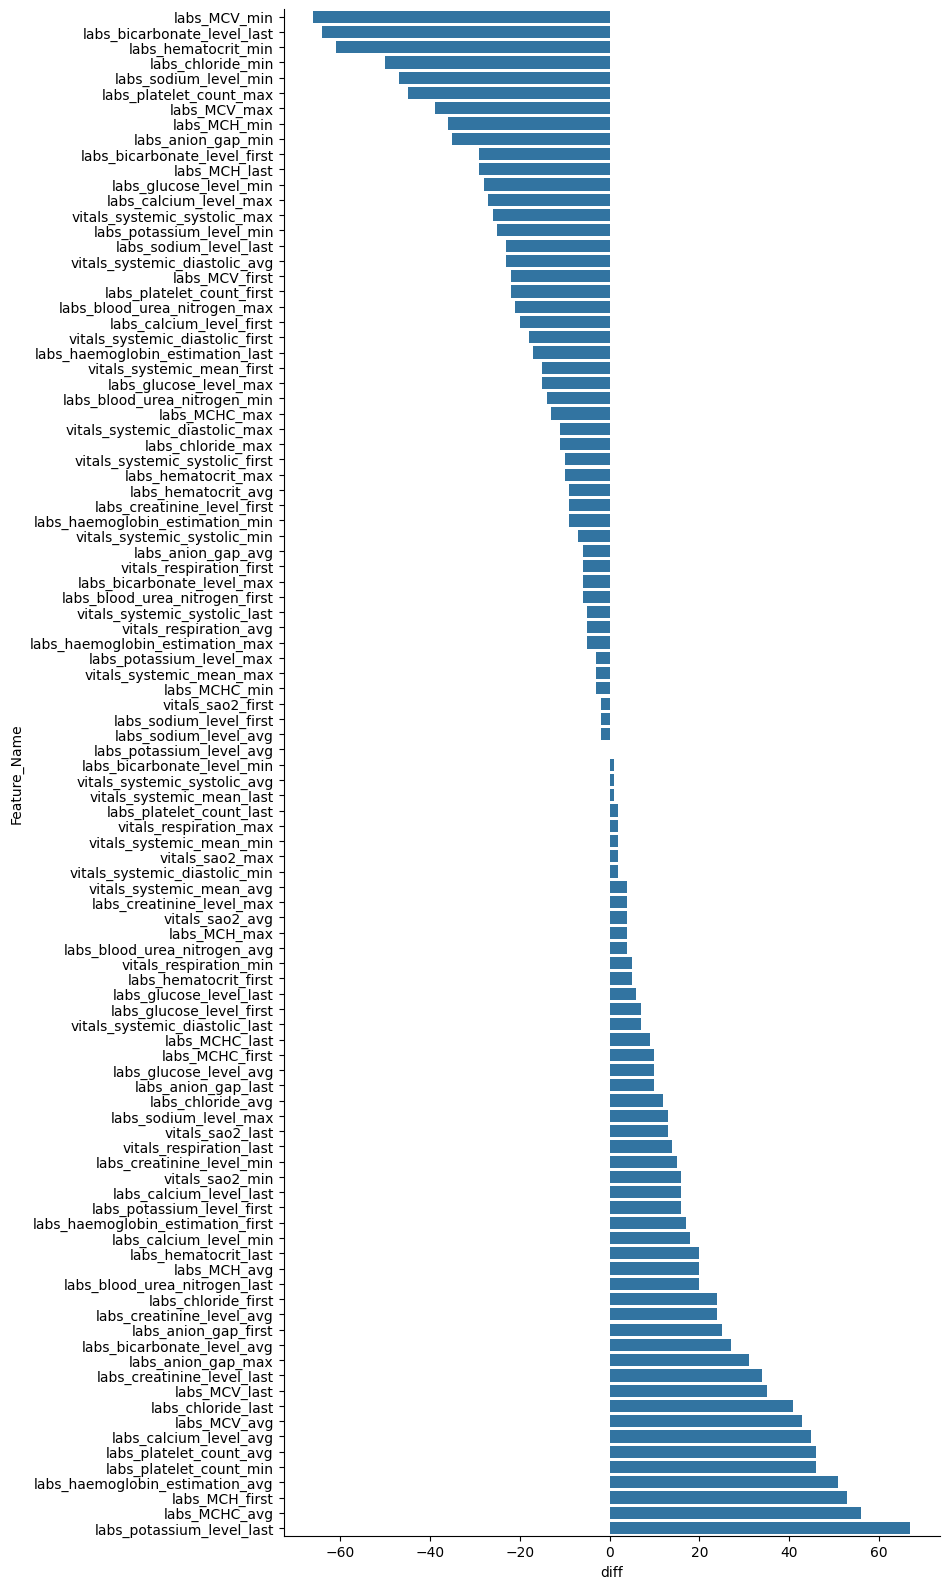

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.catplot(x="diff", y="Feature_Name",
                data=plotDf.sort_values(by='diff'), kind="bar", orient='h',
                height=16, aspect=0.6)
